<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_GRU/LSTM_GRU_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 6.33 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Jul 18 13:25:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 9.7MB/s 
     |████████████████████████████████| 143kB 42.4MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 143kB 49.3MB/s 
     |████████████████████████████████| 174kB 61.4MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [15]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: i6paymma
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_GRU/sweeps/i6paymma


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: w3qp7b8o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 22s 170ms/step - loss: 0.3642 - mean_squared_error: 0.3642 - mean_absolute_error: 0.4802 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0883
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0908 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0857
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.1046 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0831
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0906 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0752
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0184 - mean_squared_error: 0

epoch,14
loss,0.00493
mean_squared_error,0.00493
mean_absolute_error,0.05134
val_loss,0.01232
val_mean_squared_error,0.01232
val_mean_absolute_error,0.09481
_runtime,31
_timestamp,1626614854
_step,14
best_val_loss,0.00741


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁
val_loss,▄▅▄▃▁▂█▃▄▂▃▁▁▄▃
val_mean_squared_error,▄▅▄▃▁▂█▃▄▂▃▁▁▄▃
val_mean_absolute_error,▄▄▄▃▁▁█▃▄▂▃▁▁▅▅
_runtime,▁▁▁▁▁▁▁▁███████
_timestamp,▁▁▁▁▁▁▁▁███████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: vyf3b4as with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 68ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - mean_absolute_error: 0.2838 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0999
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0658 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0749
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0545 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0767
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0488 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0637
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_

epoch,199
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.02368
val_loss,0.00235
val_mean_squared_error,0.00235
val_mean_absolute_error,0.03442
_runtime,49
_timestamp,1626614911
_step,199
best_val_loss,0.00226


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▆▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁
val_mean_squared_error,█▇▆▅▆▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁
val_mean_absolute_error,█▇▆▅▆▅▄▅▄▃▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▃▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tioimi6n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 132ms/step - loss: 0.0749 - mean_squared_error: 0.0749 - mean_absolute_error: 0.1880 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1185
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0620 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1107
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0795 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0739
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0566 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0678
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0

epoch,99
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02814
val_loss,0.00362
val_mean_squared_error,0.00362
val_mean_absolute_error,0.0453
_runtime,18
_timestamp,1626614938
_step,99
best_val_loss,0.00271


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▃▂▂▂▁▁▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▇▄▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂▁▁▂▁▁▂▂▁▁
val_mean_squared_error,█▄▇▄▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂▁▁▂▁▁▂▂▁▁
val_mean_absolute_error,█▄▅▃▄▆▄▃▂▂▂▂▂▂▁▁▂▁▂▂▃▁▁▁▁▁▁▂▃▂▃▂▂▂▁▁▃▃▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0s8ltq1h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 133ms/step - loss: 0.1115 - mean_squared_error: 0.1115 - mean_absolute_error: 0.2690 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1068
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0672 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0820
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0563 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0740
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0512 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0687
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041 

epoch,49
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.03292
val_loss,0.00577
val_mean_squared_error,0.00577
val_mean_absolute_error,0.05303
_runtime,15
_timestamp,1626614975
_step,49
best_val_loss,0.00553


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▃▃▄▄▃▂▃▃▂▄▂▂▂▁▃▂▂▃▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5stfg1h7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 13s 150ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1230 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0625
Epoch 2/50
31/31 [==============================] - 4s 128ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0619 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0813
Epoch 3/50
31/31 [==============================] - 4s 125ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0594 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0631
Epoch 4/50
31/31 [==============================] - 4s 126ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0516
Epoch 5/50
31/31 [==============================] - 4s 123ms/step - loss: 0.0032 - mean_squared

epoch,49
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.0277
val_loss,0.00229
val_mean_squared_error,0.00229
val_mean_absolute_error,0.03223
_runtime,201
_timestamp,1626615194
_step,49
best_val_loss,0.00229


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▃▃▃▄▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁
val_mean_squared_error,▆█▄▃▃▃▄▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁
val_mean_absolute_error,▅█▅▄▃▃▅▃▃▃▃▅▂▂▂▂▄▂▂▃▃▂▂▂▂▃▄▂▂▁▂▂▁▄▁▁▁▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xyleeq4f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 5s 37ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - mean_absolute_error: 0.2252 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0717
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0718
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0495 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0658
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0469 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0610
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error

epoch,49
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02683
val_loss,0.00357
val_mean_squared_error,0.00357
val_mean_absolute_error,0.04057
_runtime,27
_timestamp,1626615242
_step,49
best_val_loss,0.00316


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▅▅▅▄▄▄▃▃▃▃▃▄▃▄▃▂▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▇▇▆▅▅▅▅▄▄▄▃▃▃▃▃▄▃▄▃▂▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,██▇▆▆▅▇▄▅▅▆▄▄▃▃▄▅▂▅▃▂▂▅▄▃▂▂▁▃▁▁▁▁▁▁▁▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rv6f4cwn with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 6s 263ms/step - loss: 0.2179 - mean_squared_error: 0.2179 - mean_absolute_error: 0.3640 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0775
Epoch 2/50
8/8 [==============================] - 1s 135ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0971 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1256
Epoch 3/50
8/8 [==============================] - 1s 132ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0828 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0582
Epoch 4/50
8/8 [==============================] - 1s 130ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0599 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0767
Epoch 5/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0047 - mean_squared_error: 0.0

epoch,49
loss,0.00164
mean_squared_error,0.00164
mean_absolute_error,0.03129
val_loss,0.00508
val_mean_squared_error,0.00508
val_mean_absolute_error,0.04833
_runtime,59
_timestamp,1626615309
_step,49
best_val_loss,0.00501


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▂▄▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kce6bkup with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 5s 257ms/step - loss: 0.1759 - mean_squared_error: 0.1759 - mean_absolute_error: 0.3236 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0929
Epoch 2/50
8/8 [==============================] - 1s 110ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0832 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0801
Epoch 3/50
8/8 [==============================] - 1s 122ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0723 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0648
Epoch 4/50
8/8 [==============================] - 1s 110ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0895 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0591
Epoch 5/50
8/8 [==============================] - 1s 97ms/step - loss: 0.0070 - mean_squared_error: 0.00

epoch,49
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.02939
val_loss,0.00533
val_mean_squared_error,0.00533
val_mean_absolute_error,0.0542
_runtime,58
_timestamp,1626615406
_step,49
best_val_loss,0.00377


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁
val_loss,▆▅▅▄▃▄▃█▄▅▂▃▄▂▃▃▂▂▂▂▂▄▂▂▁▃▂▃▂▁▁▂▂▁▁▂▂▁▁▂
val_mean_squared_error,▆▅▅▄▃▄▃█▄▅▂▃▄▂▃▃▂▂▂▂▂▄▂▂▁▃▂▃▂▁▁▂▂▁▁▂▂▁▁▂
val_mean_absolute_error,█▆▄▃▃▃▂█▅▇▃▃▄▂▃▄▂▂▂▂▂▆▃▃▁▄▄▄▄▁▁▂▂▁▂▂▃▂▁▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m8v9ck7s with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 7s 267ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - mean_absolute_error: 0.2561 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0975
Epoch 2/200
8/8 [==============================] - 1s 139ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0726 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0758
Epoch 3/200
8/8 [==============================] - 1s 133ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0652 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0906
Epoch 4/200
8/8 [==============================] - 1s 131ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0627 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0737
Epoch 5/200
8/8 [==============================] - 1s 130ms/step - loss: 0.0042 - mean_squared_error

epoch,113
loss,0.00237
mean_squared_error,0.00237
mean_absolute_error,0.0373
val_loss,0.00312
val_mean_squared_error,0.00312
val_mean_absolute_error,0.03685
_runtime,128
_timestamp,1626615562
_step,113
best_val_loss,0.00281


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▃▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_loss,█▇▄▅▅▅▄▃▃▇▂▃▂▃▂▂▂▂▃▂▂▂▂▁▃▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▇▄▅▅▅▄▃▃▇▂▃▂▃▂▂▂▂▃▂▂▂▂▁▃▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▃▄▄▄▃▂▃▇▃▃▃▄▂▂▂▂▃▁▂▂▂▁▄▁▁▂▃▂▂▁▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1wgu28ly with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 5s 66ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1603 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1210
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0714 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1226
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0699 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0643
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0661
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.

epoch,49
loss,0.00197
mean_squared_error,0.00197
mean_absolute_error,0.03395
val_loss,0.00352
val_mean_squared_error,0.00352
val_mean_absolute_error,0.0384
_runtime,17
_timestamp,1626615588
_step,49
best_val_loss,0.00346


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,██▃▃▃▄▂▃▂▃▂▂▂▃▂▂▃▂▂▂▃▂▂▃▅▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁
val_mean_squared_error,██▃▃▃▄▂▃▂▃▂▂▂▃▂▂▃▂▂▂▃▂▂▃▅▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,██▃▃▂▄▃▄▃▄▂▃▂▃▂▂▃▃▂▂▃▂▁▄▅▁▂▂▁▂▂▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5aenpy6k with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 195ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - mean_absolute_error: 0.2820 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0936
Epoch 2/100
16/16 [==============================] - 2s 126ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0746 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0855
Epoch 3/100
16/16 [==============================] - 2s 127ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0750
Epoch 4/100
16/16 [==============================] - 2s 124ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0568 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0658
Epoch 5/100
16/16 [==============================] - 2s 127ms/step - loss: 0.0042 - mean_squ

epoch,99
loss,0.00198
mean_squared_error,0.00198
mean_absolute_error,0.03409
val_loss,0.00504
val_mean_squared_error,0.00504
val_mean_absolute_error,0.04488
_runtime,207
_timestamp,1626615806
_step,99
best_val_loss,0.0048


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▅▄▄▃▃▃▃▄▃▃▃▂▃▂▃▂▂▂▂▂▃▂▂▂▂▁▁▁▁▂▁▂▁▁▁▂▁
val_mean_squared_error,█▅▄▅▄▄▃▃▃▃▄▃▃▃▂▃▂▃▂▂▂▂▂▃▂▂▂▂▁▁▁▁▂▁▂▁▁▁▂▁
val_mean_absolute_error,█▅▄▆▃▄▃▂▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▄▂▁▂▁▁▁▁▁▂▁▃▁▂▁▃▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pu91ffrn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 127ms/step - loss: 0.2014 - mean_squared_error: 0.2014 - mean_absolute_error: 0.3727 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1179
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1292 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0955
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0825 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0753
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0796 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0956
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0075 - mean_squared_error: 0.0

epoch,199
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02707
val_loss,0.0029
val_mean_squared_error,0.0029
val_mean_absolute_error,0.03727
_runtime,34
_timestamp,1626615853
_step,199
best_val_loss,0.00283


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fqh68k3i with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 150ms/step - loss: 0.1340 - mean_squared_error: 0.1340 - mean_absolute_error: 0.2972 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0944
Epoch 2/50
31/31 [==============================] - 4s 118ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0850 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0572
Epoch 3/50
31/31 [==============================] - 4s 114ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0460 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0572
Epoch 4/50
31/31 [==============================] - 4s 123ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0461 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0569
Epoch 5/50
31/31 [==============================] - 4s 129ms/step - loss: 0.0035 - mean_squared_

epoch,49
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.03093
val_loss,0.00474
val_mean_squared_error,0.00474
val_mean_absolute_error,0.04258
_runtime,199
_timestamp,1626616076
_step,49
best_val_loss,0.00469


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▄▃▃▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1okcvwp1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 9s 157ms/step - loss: 0.1471 - mean_squared_error: 0.1471 - mean_absolute_error: 0.3198 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0833
Epoch 2/50
31/31 [==============================] - 4s 127ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0597 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0635
Epoch 3/50
31/31 [==============================] - 4s 130ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0493 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0644
Epoch 4/50
31/31 [==============================] - 4s 132ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0503 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0548
Epoch 5/50
31/31 [==============================] - 4s 131ms/step - loss: 0.0034 - mean_squared_

epoch,49
loss,0.00188
mean_squared_error,0.00188
mean_absolute_error,0.03399
val_loss,0.00651
val_mean_squared_error,0.00651
val_mean_absolute_error,0.0494
_runtime,204
_timestamp,1626616290
_step,49
best_val_loss,0.00648


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▄▆▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▄▆▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▂▃▄▆▃▂▃▂▃▂▃▂▃▂▂▃▃▂▂▂▂▂▁▂▂▂▁▂▁▃▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1rpjj9e2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 264ms/step - loss: 0.2156 - mean_squared_error: 0.2156 - mean_absolute_error: 0.4047 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - val_mean_absolute_error: 0.2563
Epoch 2/100
8/8 [==============================] - 1s 120ms/step - loss: 0.0927 - mean_squared_error: 0.0927 - mean_absolute_error: 0.2481 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1099
Epoch 3/100
8/8 [==============================] - 1s 127ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0762 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0709
Epoch 4/100
8/8 [==============================] - 1s 128ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0626 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0655
Epoch 5/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0043 - mean_squared_error

epoch,99
loss,0.00222
mean_squared_error,0.00222
mean_absolute_error,0.03627
val_loss,0.00577
val_mean_squared_error,0.00577
val_mean_absolute_error,0.04673
_runtime,116
_timestamp,1626616415
_step,99
best_val_loss,0.0055


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fo2vvy2f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 250ms/step - loss: 0.1379 - mean_squared_error: 0.1379 - mean_absolute_error: 0.2843 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1153
Epoch 2/50
8/8 [==============================] - 1s 124ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0822 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0727
Epoch 3/50
8/8 [==============================] - 1s 122ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0764 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0833
Epoch 4/50
8/8 [==============================] - 1s 142ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0664 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0678
Epoch 5/50
8/8 [==============================] - 1s 139ms/step - loss: 0.0066 - mean_squared_error: 0.0

epoch,49
loss,0.00219
mean_squared_error,0.00219
mean_absolute_error,0.03629
val_loss,0.0062
val_mean_squared_error,0.0062
val_mean_absolute_error,0.052
_runtime,62
_timestamp,1626616542
_step,49
best_val_loss,0.0062


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁
val_mean_squared_error,█▄▅▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,█▃▄▃▂▃▂▂▂▂▂▃▂▃▂▂▂▂▁▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jijel6at with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 149ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - mean_absolute_error: 0.1944 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0771
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0554 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0581
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0720 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0618
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0462 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1373
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0157 - mean_squared_error: 0.0157 

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.02914
val_loss,0.00337
val_mean_squared_error,0.00337
val_mean_absolute_error,0.04071
_runtime,18
_timestamp,1626616571
_step,49
best_val_loss,0.00321


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▃▃▂▂▂▂▂▁▂▂▁▂▃▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁
val_loss,▃▃▃█▃▂▃▂▃▃▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁
val_mean_squared_error,▃▃▃█▃▂▃▂▃▃▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁
val_mean_absolute_error,▄▂▃█▃▂▂▂▄▃▄▂▄▃▃▃▂▂▄▂▂▂▃▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ywznnqlm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 8s 149ms/step - loss: 0.6701 - mean_squared_error: 0.6701 - mean_absolute_error: 0.4537 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1487
Epoch 2/100
31/31 [==============================] - 4s 130ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1093 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0755
Epoch 3/100
31/31 [==============================] - 4s 123ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.0854 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0513
Epoch 4/100
31/31 [==============================] - 4s 122ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0736 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1711
Epoch 5/100
31/31 [==============================] - 4s 122ms/step - loss: 0.0220 - mean_squ

epoch,25
loss,0.00272
mean_squared_error,0.00272
mean_absolute_error,0.04138
val_loss,0.00234
val_mean_squared_error,0.00234
val_mean_absolute_error,0.03235
_runtime,112
_timestamp,1626616695
_step,25
best_val_loss,0.00227


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▂█▂▂▁▁▄▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁
val_mean_squared_error,▆▃▂█▂▂▁▁▄▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁
val_mean_absolute_error,▇▃▂█▂▃▂▂▄▂▂▂▂▂▁▁▁▁▁▁▃▂▁▁▂▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 0pfeq1zx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 9s 155ms/step - loss: 0.1067 - mean_squared_error: 0.1067 - mean_absolute_error: 0.2159 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0776
Epoch 2/200
31/31 [==============================] - 4s 125ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0801 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0619
Epoch 3/200
31/31 [==============================] - 4s 120ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0657 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0879
Epoch 4/200
31/31 [==============================] - 4s 118ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0548 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0598
Epoch 5/200
31/31 [==============================] - 3s 112ms/step - loss: 0.0050 - mean_squ

epoch,74
loss,0.00131
mean_squared_error,0.00131
mean_absolute_error,0.02824
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.03435
_runtime,310
_timestamp,1626617015
_step,74
best_val_loss,0.00221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▆▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▄▄▆▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,▆▅▄█▄▃▃▂▂▂▃▂▂▂▁▃▁▁▁▁▂▁▂▂▁▁▁▂▂▁▂▂▁▃▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7b6siegv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 8s 155ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - mean_absolute_error: 0.2136 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0635
Epoch 2/200
31/31 [==============================] - 4s 123ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0607 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0781
Epoch 3/200
31/31 [==============================] - 4s 126ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0655
Epoch 4/200
31/31 [==============================] - 4s 127ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0476 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0561
Epoch 5/200
31/31 [==============================] - 4s 124ms/step - loss: 0.0039 - mean_squ

epoch,123
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.0265
val_loss,0.00244
val_mean_squared_error,0.00244
val_mean_absolute_error,0.03596
_runtime,507
_timestamp,1626617533
_step,123
best_val_loss,0.00226


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▇▅▅▄▃▃▄▆▄▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▇▅▅▄▃▃▄▆▄▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅▇▆█▅▆▃▃▃▄▇▅▃▂▃▄▂▂▃▂▂▂▂▂▁▁▂▁▁▂▁▂▁▂▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jzg9gifs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 5s 40ms/step - loss: 0.0612 - mean_squared_error: 0.0612 - mean_absolute_error: 0.1849 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0993
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0559 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0635
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0456 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0665
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0445 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0668
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_squared_error

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.029
val_loss,0.00371
val_mean_squared_error,0.00371
val_mean_absolute_error,0.04461
_runtime,28
_timestamp,1626617593
_step,49
best_val_loss,0.00328


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▃▂▁▂▁▂▁▁▁▂▁▃▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 41ur7mvy with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 6s 269ms/step - loss: 0.1385 - mean_squared_error: 0.1385 - mean_absolute_error: 0.3012 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0836
Epoch 2/50
8/8 [==============================] - 1s 135ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0745 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0952
Epoch 3/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0691 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0770
Epoch 4/50
8/8 [==============================] - 1s 131ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0609 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0756
Epoch 5/50
8/8 [==============================] - 1s 131ms/step - loss: 0.0050 - mean_squared_error: 0.0

epoch,49
loss,0.00283
mean_squared_error,0.00283
mean_absolute_error,0.04082
val_loss,0.00819
val_mean_squared_error,0.00819
val_mean_absolute_error,0.0582
_runtime,65
_timestamp,1626617670
_step,49
best_val_loss,0.00615


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▅▄▅▅▄█▃▆▄▃▅▃▃▃▄▃▂▄▂▂▃▃▂▄▂▂▂▂▂▃▁▁▄▁▃▁▃
val_mean_squared_error,▇█▅▅▄▅▅▄█▃▆▄▃▅▃▃▃▄▃▂▄▂▂▃▃▂▄▂▂▂▂▂▃▁▁▄▁▃▁▃
val_mean_absolute_error,▆█▅▅▄▅▅▃▄▂▆▄▂▃▂▃▃▅▃▁▂▁▂▁▂▁▃▁▁▂▃▂▄▁▂▅▁▅▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 91kww157 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 5s 34ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1883 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0970
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0568 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0688
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0477 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0672
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0477 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0613
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_erro

epoch,129
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.02248
val_loss,0.00208
val_mean_squared_error,0.00208
val_mean_absolute_error,0.03144
_runtime,55
_timestamp,1626617736
_step,129
best_val_loss,0.00206


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▅▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▇▅▅▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▆▅▄▄▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁
val_loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▆▅▅▅▄▄▄▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 38e9zbrg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 5s 45ms/step - loss: 0.0714 - mean_squared_error: 0.0714 - mean_absolute_error: 0.1856 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0710
Epoch 2/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0727
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0484 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0581
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0487 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0598
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_

epoch,146
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02258
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03352
_runtime,73
_timestamp,1626617855
_step,146
best_val_loss,0.00199


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▁▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁
mean_squared_error,██▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▁▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,██▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁
val_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▇▄▄▅▄▃▃▄▃▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n321hn3l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 145ms/step - loss: 0.1814 - mean_squared_error: 0.1814 - mean_absolute_error: 0.3445 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0977
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0782 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0866
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0656 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1004
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0669 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0693
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.

epoch,99
loss,0.00196
mean_squared_error,0.00196
mean_absolute_error,0.03326
val_loss,0.00441
val_mean_squared_error,0.00441
val_mean_absolute_error,0.04308
_runtime,24
_timestamp,1626617906
_step,99
best_val_loss,0.00441


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▄▄▅▄▄▃▃▃▃▃▂▂▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▄▄▄▅▄▄▃▃▃▃▃▂▂▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▃▃▃▃▆▄▅▂▂▃▂▄▂▂▂▃▂▄▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: om793stu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 9s 161ms/step - loss: 0.0612 - mean_squared_error: 0.0612 - mean_absolute_error: 0.1704 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0593
Epoch 2/100
31/31 [==============================] - 4s 128ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0653 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1251
Epoch 3/100
31/31 [==============================] - 4s 127ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0630 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0594
Epoch 4/100
31/31 [==============================] - 4s 137ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0469 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0520
Epoch 5/100
31/31 [==============================] - 4s 141ms/step - loss: 0.0045 - mean_squ

epoch,76
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.02966
val_loss,0.00289
val_mean_squared_error,0.00289
val_mean_absolute_error,0.039
_runtime,327
_timestamp,1626618250
_step,76
best_val_loss,0.00249


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▂▃▄▃▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h0uyznok with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 195ms/step - loss: 0.1914 - mean_squared_error: 0.1914 - mean_absolute_error: 0.3780 - val_loss: 0.0603 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1944
Epoch 2/100
16/16 [==============================] - 2s 134ms/step - loss: 0.0602 - mean_squared_error: 0.0602 - mean_absolute_error: 0.1965 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1219
Epoch 3/100
16/16 [==============================] - 2s 132ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.1002 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0778
Epoch 4/100
16/16 [==============================] - 2s 130ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0741 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0743
Epoch 5/100
16/16 [==============================] - 2s 129ms/step - loss: 0.0051 - mean_squ

epoch,99
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.03258
val_loss,0.00599
val_mean_squared_error,0.00599
val_mean_absolute_error,0.04978
_runtime,225
_timestamp,1626618512
_step,99
best_val_loss,0.00599


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4r8jmnd7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 68ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2216 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0726
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0858 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0951
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0571 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0665
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0455 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0612
Epoch 5/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0032 - mean_squared_

epoch,199
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.02429
val_loss,0.00225
val_mean_squared_error,0.00225
val_mean_absolute_error,0.03403
_runtime,54
_timestamp,1626618579
_step,199
best_val_loss,0.00212


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nyvpwcyw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 260ms/step - loss: 0.1354 - mean_squared_error: 0.1354 - mean_absolute_error: 0.2761 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1115
Epoch 2/100
8/8 [==============================] - 1s 148ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0851 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0780
Epoch 3/100
8/8 [==============================] - 1s 131ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0641 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0712
Epoch 4/100
8/8 [==============================] - 1s 138ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0617 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0646
Epoch 5/100
8/8 [==============================] - 1s 139ms/step - loss: 0.0074 - mean_squared_error

epoch,99
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.03005
val_loss,0.00441
val_mean_squared_error,0.00441
val_mean_absolute_error,0.04393
_runtime,122
_timestamp,1626618752
_step,99
best_val_loss,0.00441


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▅▃▂▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▂▂▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vwgo17pu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 281ms/step - loss: 1.0242 - mean_squared_error: 1.0242 - mean_absolute_error: 0.6224 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0623
Epoch 2/50
8/8 [==============================] - 1s 142ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0563 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0540
Epoch 3/50
8/8 [==============================] - 1s 137ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0589 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0565
Epoch 4/50
8/8 [==============================] - 1s 141ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0516 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0516
Epoch 5/50
8/8 [==============================] - 1s 153ms/step - loss: 0.0039 - mean_squared_error: 0.0

epoch,49
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.02772
val_loss,0.00349
val_mean_squared_error,0.00349
val_mean_absolute_error,0.04182
_runtime,66
_timestamp,1626618835
_step,49
best_val_loss,0.00307


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▆▅▅▇█▄▄▃▅▃▃▃▄▄▃▅▂▂▃▂▄▂▂▃▂▂▄▁▂▂▁▁▁▂▁▁▁
val_mean_squared_error,█▆▅▆▅▅▇█▄▄▃▅▃▃▃▄▄▃▅▂▂▃▂▄▂▂▃▂▂▄▁▂▂▁▁▁▂▁▁▁
val_mean_absolute_error,▆▄▅▄▄▄▇█▄▃▃▅▃▃▃▃▄▃▅▂▂▃▃▄▂▂▄▂▃▅▁▂▃▁▁▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tuoshroe with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 9s 171ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1242 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0646
Epoch 2/100
31/31 [==============================] - 4s 130ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0505 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0589
Epoch 3/100
31/31 [==============================] - 4s 126ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0542
Epoch 4/100
31/31 [==============================] - 4s 127ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0421 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0553
Epoch 5/100
31/31 [==============================] - 4s 117ms/step - loss: 0.0028 - mean_squ

epoch,99
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02487
val_loss,0.00207
val_mean_squared_error,0.00207
val_mean_absolute_error,0.03109
_runtime,420
_timestamp,1626619270
_step,99
best_val_loss,0.00205


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▄▅▄▄▄▄▃▃▄▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o5z7ulon with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 154ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - mean_absolute_error: 0.1863 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0737
Epoch 2/50
31/31 [==============================] - 4s 126ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0751 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0713
Epoch 3/50
31/31 [==============================] - 4s 140ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0603 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0585
Epoch 4/50
31/31 [==============================] - 4s 136ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0507 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0684
Epoch 5/50
31/31 [==============================] - 4s 134ms/step - loss: 0.0044 - mean_squared_

epoch,49
loss,0.00151
mean_squared_error,0.00151
mean_absolute_error,0.0298
val_loss,0.00299
val_mean_squared_error,0.00299
val_mean_absolute_error,0.03964
_runtime,216
_timestamp,1626619531
_step,49
best_val_loss,0.00269


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▅▆▄▃▄▃▂▃▃▂▂▂▂▃▂▃▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▆▄▅▆▄▃▄▃▂▃▃▂▂▂▂▃▂▃▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,██▅▇█▅▅▅▄▃▄▃▃▂▂▂▄▃▄▂▂▃▃▂▁▁▂▂▂▂▂▁▁▂▁▂▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xoi3l8os with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 9s 173ms/step - loss: 0.4057 - mean_squared_error: 0.4057 - mean_absolute_error: 0.4268 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0709
Epoch 2/50
31/31 [==============================] - 4s 130ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0943 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0953
Epoch 3/50
31/31 [==============================] - 4s 129ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.1022 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1242
Epoch 4/50
31/31 [==============================] - 4s 127ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0923 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0645
Epoch 5/50
31/31 [==============================] - 4s 128ms/step - loss: 0.0126 - mean_squared_

epoch,21
loss,0.00279
mean_squared_error,0.00279
mean_absolute_error,0.04262
val_loss,0.00399
val_mean_squared_error,0.00399
val_mean_absolute_error,0.04909
_runtime,100
_timestamp,1626619700
_step,21
best_val_loss,0.00265


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,▆▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▆▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃▅▂▅▂▁█▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▂▃▅▂▅▂▁█▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▃▄▅▂▆▂▁█▁▁▁▁▂▂▂▁▂▂▂▁▂▂
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: ctizhi3o with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 187ms/step - loss: 0.1595 - mean_squared_error: 0.1595 - mean_absolute_error: 0.2783 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0789
Epoch 2/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0637 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0686
Epoch 3/50
16/16 [==============================] - 2s 135ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0588
Epoch 4/50
16/16 [==============================] - 2s 132ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0514 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0621
Epoch 5/50
16/16 [==============================] - 2s 135ms/step - loss: 0.0041 - mean_squared_

epoch,49
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02928
val_loss,0.00439
val_mean_squared_error,0.00439
val_mean_absolute_error,0.04418
_runtime,119
_timestamp,1626619880
_step,49
best_val_loss,0.00439


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▄▄▄▅▃▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▅▅▄▄▄▅▃▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▄▅▅▄▄▃▅▃▄▄▄▃▃▂▂▃▃▃▄▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dsioijk4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 6s 292ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.2022 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0876
Epoch 2/50
8/8 [==============================] - 1s 145ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0635 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0897
Epoch 3/50
8/8 [==============================] - 1s 139ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0779 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0661
Epoch 4/50
8/8 [==============================] - 1s 140ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0659 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0589
Epoch 5/50
8/8 [==============================] - 1s 139ms/step - loss: 0.0062 - mean_squared_error: 0.0

epoch,49
loss,0.00217
mean_squared_error,0.00217
mean_absolute_error,0.03585
val_loss,0.00594
val_mean_squared_error,0.00594
val_mean_absolute_error,0.0582
_runtime,66
_timestamp,1626619992
_step,49
best_val_loss,0.0047


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▃▂▃▃▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁
val_loss,▅█▅▃▃▃▃▂▂▃▂▃▂▂▂▂▃▂▃▂▁▁▁▁▁▂▁▂▃▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▅█▅▃▃▃▃▂▂▃▂▃▂▂▂▂▃▂▃▂▁▁▁▁▁▂▁▂▃▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,██▄▃▃▃▃▃▃▃▂▆▄▄▄▄▄▃▆▃▂▂▂▂▂▂▂▃▄▁▂▁▁▂▁▁▁▁▁▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9vf5ofet with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 137ms/step - loss: 0.1554 - mean_squared_error: 0.1554 - mean_absolute_error: 0.3190 - val_loss: 0.0468 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.2066
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1572 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0790
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0896 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0731
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0701 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1030
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067 

epoch,49
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.03587
val_loss,0.00701
val_mean_squared_error,0.00701
val_mean_absolute_error,0.0584
_runtime,19
_timestamp,1626620051
_step,49
best_val_loss,0.0068


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z6dszkvg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 148ms/step - loss: 0.0931 - mean_squared_error: 0.0931 - mean_absolute_error: 0.2170 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0713
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0668 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0606
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0515 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0641
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0399 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0580
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0093 - mean_squared_error: 0.0093 

epoch,49
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.04068
val_loss,0.00369
val_mean_squared_error,0.00369
val_mean_absolute_error,0.04691
_runtime,20
_timestamp,1626620090
_step,49
best_val_loss,0.00294


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▃▃▂▂▂▃▃▂▂▃▂▂▂▁▁▃▁▁▂▂▁▁▂▁▂▁▁▂▂▁▂▁▁▁▂
val_loss,▇▆▅▆██▇▇▄▄▇▃▃▄▂▃▂▃▂▂▂▂▂▂▂▂▄▂▃▂▁▂▁▁▁▁▁▂▁▂
val_mean_squared_error,▇▆▅▆██▇▇▄▄▇▃▃▄▂▃▂▃▂▂▂▂▂▂▂▂▄▂▃▂▁▂▁▁▁▁▁▂▁▂
val_mean_absolute_error,▆▄▅▄██▇▇▄▅▇▃▃▄▂▃▂▂▂▂▂▂▂▂▂▂▄▂▄▂▁▂▁▁▁▁▂▂▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ty5m5zci with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 9s 163ms/step - loss: 0.0682 - mean_squared_error: 0.0682 - mean_absolute_error: 0.1702 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0673
Epoch 2/100
31/31 [==============================] - 4s 127ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0552 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0574
Epoch 3/100
31/31 [==============================] - 4s 137ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0493 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0619
Epoch 4/100
31/31 [==============================] - 4s 135ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0459 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0560
Epoch 5/100
31/31 [==============================] - 4s 127ms/step - loss: 0.0029 - mean_squ

epoch,99
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02494
val_loss,0.0023
val_mean_squared_error,0.0023
val_mean_absolute_error,0.03282
_runtime,425
_timestamp,1626620532
_step,99
best_val_loss,0.0023


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▅▄▄▆▅▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9a4qjht7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 162ms/step - loss: 0.1461 - mean_squared_error: 0.1461 - mean_absolute_error: 0.3164 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1200
Epoch 2/200
31/31 [==============================] - 4s 126ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0918 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0650
Epoch 3/200
31/31 [==============================] - 4s 130ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0495 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0563
Epoch 4/200
31/31 [==============================] - 4s 132ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0438 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0644
Epoch 5/200
31/31 [==============================] - 4s 127ms/step - loss: 0.0034 - mean_squ

epoch,125
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.02664
val_loss,0.00262
val_mean_squared_error,0.00262
val_mean_absolute_error,0.03421
_runtime,537
_timestamp,1626621084
_step,125
best_val_loss,0.00257


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6l9nvqel with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 134ms/step - loss: 0.0972 - mean_squared_error: 0.0972 - mean_absolute_error: 0.2347 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0790
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0983 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0703
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0814 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0931
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0591 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0501
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0030 - mean_squared_error: 0.

epoch,99
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.0253
val_loss,0.00229
val_mean_squared_error,0.00229
val_mean_absolute_error,0.03232
_runtime,26
_timestamp,1626621159
_step,99
best_val_loss,0.00229


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: spamgpg9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
 1/16 [>.............................] - ETA: 1:09 - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1320

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001,
    'dropout': 0.2,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, activation='tanh'))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  41921


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 3s 6ms/step - loss: 0.0445
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 3/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 5/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 6/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 7/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 8/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 10/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 11/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 12/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 13/100
39/39 [=================

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

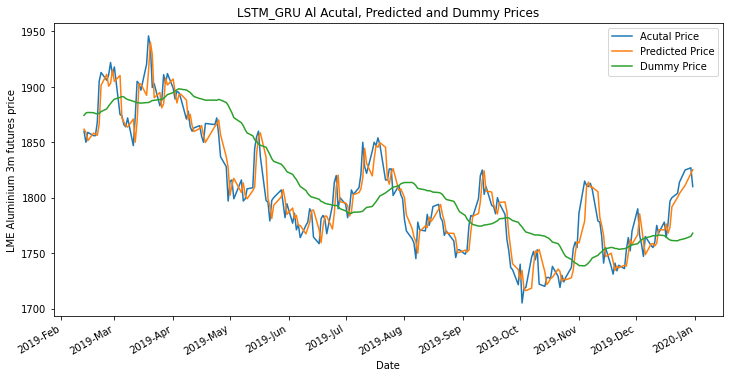

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

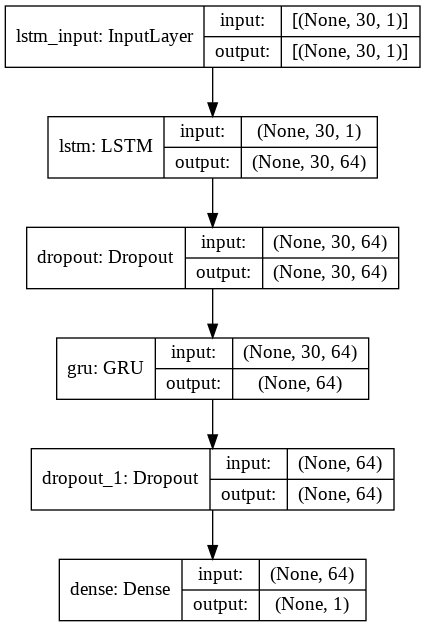

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003618918914584532
RMSE:  0.060157451031310594
MAE:  0.047400128847250485
Dummy MSE:  0.019334874061718535
Dummy RMSE:  0.13904989774076978
Dummy MAE:  0.11616489589341868


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_Al/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_Al/assets
